# Árboles de desición
  
Ésta notebook continua los ejemplos de árboles de desión utilizando datos meteorológicos de la estación meteorológica en Ezeiza. En este caso buscaremos estimar la visibilidad con un modelo de regresión.

`data` es un diccionario que incluye 'dates', 'temperature', 'dewpoint', 'windspeed', 'winddir', 'vis', 'rh', 'pressure', 'undef' (`data.keys()`). 

In [1]:
import SynopDataModule as SDM # para la lectura de los datos
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from graphviz import Source

# para guardar figuras de los arboles 
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Lectura de los datos
data = SDM.read_raw_data("../Datos/EXP_133453_HORA.txt")

## Regresión

Para arrancar usamos un solo predictor:

* humedad relativa -- valores cercanos a 100% de humedad deberían estar asociados a niebla 

Pero en este caso, intentaremos estimar el valor de visibilidad (`vis`). 

Cómo antes dividimos los datos en `train` y `test. 

In [2]:
# filtro datos faltantes
not_missing = np.logical_and(data["rh"] != data["undef"], 
                             data["vis"] != data["undef"])

predictores = ["rh"]

# los datos deben estar en arrays
x_values = np.array([data[x][not_missing] for x in predictores], dtype=object).transpose()
y_values = data["vis"][not_missing]

# separamos los datos en entrenamiento (train) y testeo (testeo)
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [3]:
tree_reg = DecisionTreeRegressor(max_depth = 3, random_state = 42)
tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

El árbol tiene la siguiente pinta. Siendo `value` el valor de visibilidad predicho en cada caso y `squared_error` el error de la estimación. 

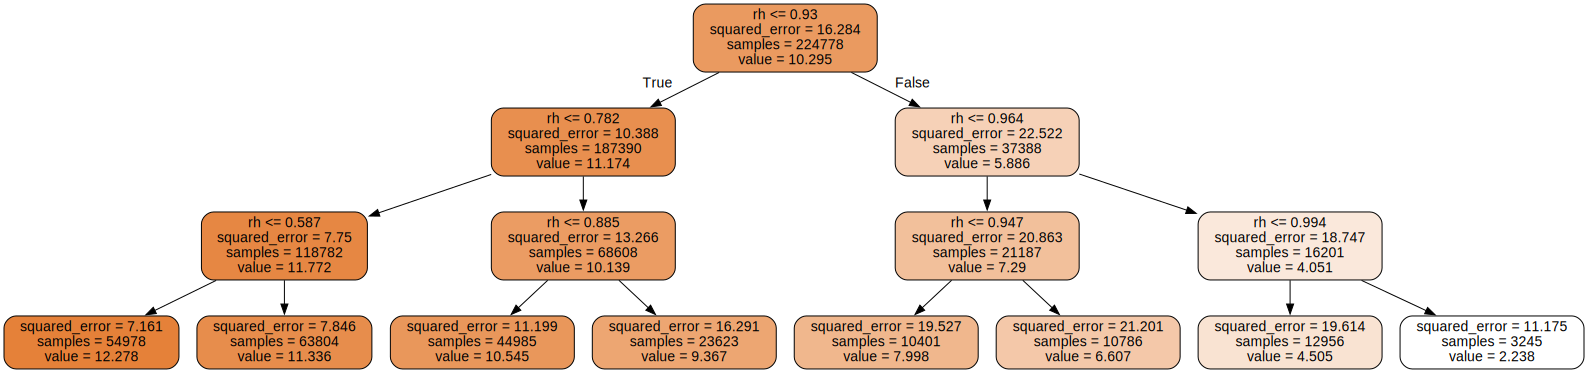

In [4]:
export_graphviz(
    tree_reg,
    out_file = str(IMAGES_PATH / "regression_tree.dot"),
    feature_names = predictores,
    rounded = True,
    filled = True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

El método `score` nos permite acceder al coeficiente de determinación de la predicción que generamos con los datos de testeo. Esto es el R^2. 

En este caso el R^2 no es muy bueno, solo 0.316. Pero es nuestro primer árbol de regresión. 

In [5]:
tree_reg.score(x_test, y_test)

0.31295641251813866

Podemos visualizar los valores predichos (línea negra), que son constantes en los límites de cada umbral de `rh` generado durante el entrenamiento del modelo (líneas rojas en el gráfico). 

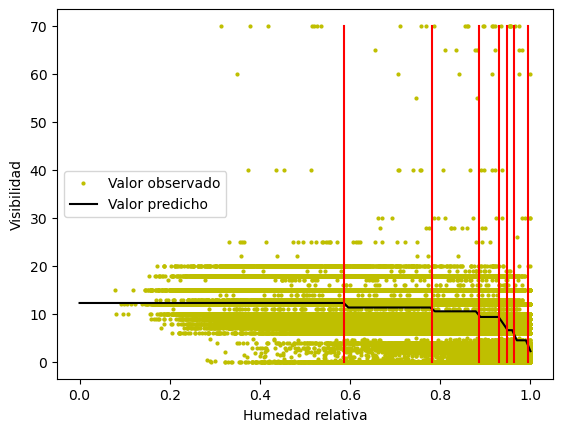

In [6]:
th = tree_reg.tree_.threshold[tree_reg.tree_.threshold != -2.]

x1 = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = tree_reg.predict(x1)


plt.figure()
plt.plot(x_values, y_values, "yo", markersize = 2, label = "Valor observado")
plt.plot(x1, y_pred, "k-", label = "Valor predicho")
for t in th:
    plt.plot([t, t], [0, 70], "r-")
plt.xlabel("Humedad relativa")
plt.ylabel("Visibilidad")
plt.legend()

Ahora que tenemos una idea de cómo funciona un árbol de regresión podemos agregar otros predictores:

* la velocidad del viento
* la hora del día, que extraemos de la fecha
* la temperatura

In [7]:
# filtro datos faltantes
not_missing = np.logical_and(np.logical_and(np.logical_and(data["rh"] != data["undef"], 
                             data["windspeed"] != data["undef"]), data["vis"] != data["undef"]),
                             data["temperature"] != data["undef"])

# extraemos la hora del día de `dates`
data["hours"] = np.array([x.hour for x in data["dates"]])

predictores = ["rh", "windspeed", "temperature", "hours"]

# los datos deben estar en arrays
x_values = np.array([data[x][not_missing] for x in predictores], dtype=object).transpose()
y_values = data["vis"][not_missing]

# separamos los datos en entrenamiento (train) y testeo (testeo)
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [8]:
tree_reg = DecisionTreeRegressor(max_depth = 3, random_state = 42)
tree_reg.fit(x_train, y_train)

tree_reg.score(x_test, y_test)

0.3287964973134534

El R^2 del árbol que incluye más predictores es un poco mejor, subió a 0.328. Sin embargo, podría mejorar aún más con alguna técnica de regularización. 

## Elección de hiperparámetros

Antes definimos `max_depth = 3` de manera arbitraria, podemos evaluar la performance del modelo utilizando distintas combinaciones de hiperparámetros. Para eso aprovechamos `GridSearchCV` que utiliza cross validation para definir que parámetros dan el mejor modelo. 

En este caso usaremos `max_leaf_nodes`, `max_depth` y `min_samples_split`. Cómo estamos entrenando un árbol para cada combinación de estos parámetros, puede demorar. 

In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': [2, 10, 20, 30, 40, 50], 
    'max_depth': list(range(1, 7)),
    'min_samples_split': [1000, 5000, 10000]
}
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state = 42),
                              params,
                              cv = 3)

grid_search_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 10, 20, 30, 40, 50],
                         'min_samples_split': [1000, 5000, 10000]})

`best_estimator_` nos devuelve el modelo que genera la mejor estimación. 

In [10]:
grid_search_cv.best_estimator_

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=50, min_samples_split=1000,
                      random_state=42)

Por defecto `GridSearchCV` entrena el mejor modelo que encontró, por lo que podemos calcular el R^2 directamente usando los datos de testeo como antes. 

En este caso el R^2 aumenta "considerablemente". 

In [11]:
grid_search_cv.score(x_test, y_test)

0.37959911843030336

## Ensemble learning

Ahora que tenemos un "mejor modelo", podemos aprovechar las ventajas de Random Forest. Que, según la teoría, debería darnos un modelo con una mejor performance que si usáramos un árbol individual. 

Para aplicar random forest para calcular una regresión usamos `RandomForestRegressor` (hay un equivalente para clasificación). 

En este caso `n_estimators` el la cantidad del árboles en el bosque, y `n_jobs = -1` significa que usaremos todos los procesadores disponibles. Aún así es posible que demore. 

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators = 500, max_depth = 6, max_leaf_nodes = 50, min_samples_split=1000,
                                n_jobs = -1, random_state = 42)
rf_reg.fit(x_train, y_train)


RandomForestRegressor(max_depth=6, max_leaf_nodes=50, min_samples_split=1000,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [13]:
rf_reg.score(x_test, y_test)

0.3884812378097464

El R^2 del bosque, cómo era de esperarse, es algo mejor que el R^2 del árbol individual. 

## Ejercicios 

1. Evaluar la performance del modelo modificando el tamaño del ensamble (cantidad del árboles en el bosque). 
2. Analizar los resultados si además de generar distintos datasets usando boostrap, se aplica boostrap en la selección de predictores (Random subspaces). 